In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import set_style
from datetime import datetime, timedelta

from sklearn.linear_model import LinearRegression

from statsmodels.tsa.holtwinters import Holt

import pickle

In [2]:
#Import the file
raw = pd.read_csv("sp500.csv")

# Reversing the order of rows
raw = raw.iloc[::-1].reset_index(drop=True)

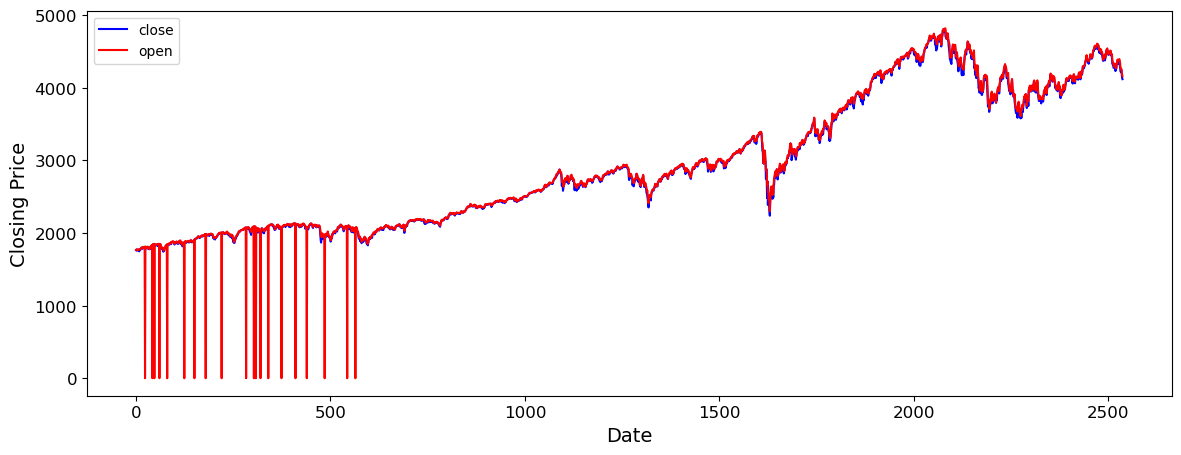

In [3]:
plt.figure(figsize=(14,5))

plt.plot(raw['Close/Last'], color='blue', label='close')
plt.plot(raw['High'], color='red', label='open')


plt.xlabel("Date", fontsize=14)
plt.ylabel("Closing Price", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend()

plt.show()

In [4]:
# Deleting zero rows indicating market/bank holidays
data=raw[raw["High"]!=0].reset_index(drop=True)

# Change the date to actual date format
data.rename(columns={'Close/Last': 'Close'}, inplace=True)

# Change the date to actual date format
data['Date'] = pd.to_datetime(data['Date'])

## Define new variables

# This tracks the daily difference between High and Low
data['HiLo']=data['High']-data['Low']

# This tracks the daily difference between Closing and Opening Data
data['OpCl']= data['Close'] - data['Open']

# This tracks the difference between Opening Data of a Day and Closing Data of the Previous Day
data['overnight']=data['Open']-data['Close'].shift(1)

In [5]:
data

,Date,Close,Open,High,Low,HiLo,OpCl,overnight
0,2013-10-28,1762.11,1759.42,1764.99,1757.67,7.32,2.69,NaN
1,2013-10-29,1771.95,1762.93,1772.09,1762.93,9.16,9.02,0.82
2,2013-10-30,1763.31,1772.27,1775.22,1757.24,17.98,-8.96,0.32
3,2013-10-31,1756.54,1763.24,1768.53,1755.72,12.81,-6.70,-0.07
4,2013-11-01,1761.64,1758.70,1765.67,1752.70,12.97,2.94,2.16
...,...,...,...,...,...,...,...,...
2513,2023-10-23,4217.04,4210.40,4255.84,4189.22,66.62,6.64,-13.76
2514,2023-10-24,4247.68,4235.79,4259.38,4219.43,39.95,11.89,18.75
2515,2023-10-25,4186.77,4232.42,4232.42,4181.42,51.00,-45.65,-15.26
2516,2023-10-26,4137.23,4175.99,4183.60,4127.90,55.70,-38.76,-10.78


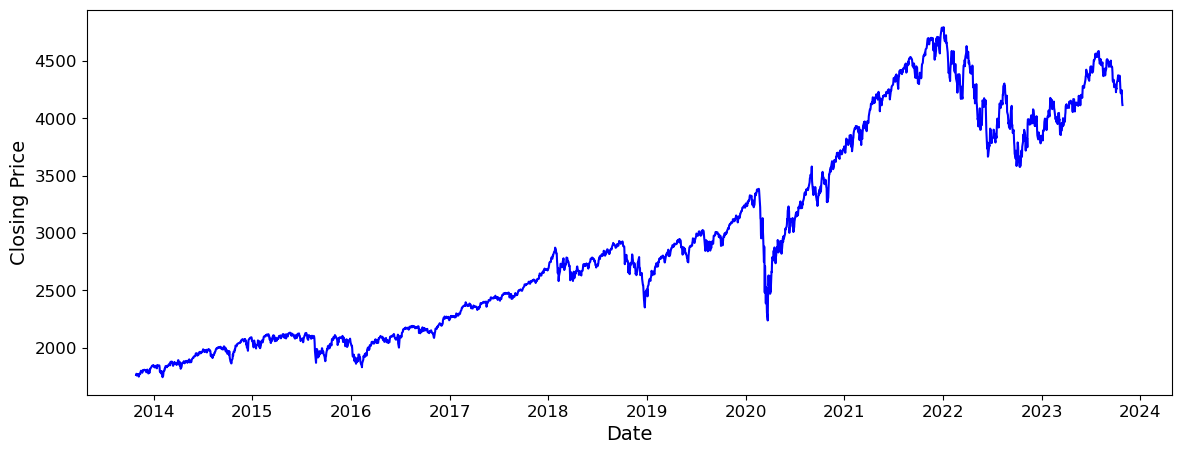

In [6]:
plt.figure(figsize=(14,5))

plt.plot(data['Date'],data['Close'], color='blue', label='close')

plt.xlabel("Date", fontsize=14)
plt.ylabel("Closing Price", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

Data seems to have an upward trend

# Baseline forecasts

In [7]:
# Split the data into training set and test set
testsize = 14


data_train = data.iloc[:-testsize].copy()
data_test = data.iloc[-testsize:].copy()

##### The average forecast

In [8]:
# Average of all closing data
train_close_avg = data_train.Close.mean()


#### The naive forecast

In [9]:
# The latest data point in the training set
naive_close = data_train.Close.values[-1]

##### The trend forecast

In [10]:
slr1 = LinearRegression()
slr2 = LinearRegression()

#Close
slr1.fit(np.arange(1, len(data_train) + 1).reshape(-1,1),
        data_train.Close)

future_predicion_days=10

trend_close_pred = slr1.predict(np.arange(len(data_train)+1, len(data_test) + len(data_train)+1+future_predicion_days).reshape(-1,1))


##### Random walk with drift forecast

In [11]:
# Close
beta_hat_1 = data_train.Close.diff().mean()

drift_pred_1 = data_train.Close.values[-1] + beta_hat_1*np.arange(1,len(data_test) + 1)
drift_pred_2 = data_train.Close.values[-1] + beta_hat_1*np.arange(1,len(data_test) + 11)

#### moving average 

In [12]:
window_size_cl = 2   ### found it in Analysis-Copy4

#Close
moving_average_close = data_train['Close'].rolling(window=window_size_cl).mean()

# RMSE

In [13]:
# Calculate the average cross-validation root mean squared error for these models. 
# Set up this cross-validation so that there are ten splits and each holdout set only has three observations in it.

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [14]:
mses_cl = np.zeros((5,10))   # 5 is the number of models, 10 is the number of splits

mses_OpCl = np.zeros((5,10))

kfold = TimeSeriesSplit(10, 
                     test_size=3)

In [15]:
j = 0  # counter for the kfold split

for train_index, test_index in kfold.split(data_train):
    data_tt = data_train.loc[train_index]
    data_ho = data_train.loc[test_index]

        
    ############## average ##############  
        #Close
    tt_close_avg = data_tt.Close.mean()
    
    mses_cl[0,j] = np.sqrt(mean_squared_error(data_ho.Close,
                                    tt_close_avg*np.ones(3)))

    
    ############### naive ###############
         #Close
    tt_naive_close = data_tt.Close.values[-1]
    
    mses_cl[1,j] = np.sqrt(mean_squared_error(data_ho.Close.values,
                                    tt_naive_close*np.ones(3)))

    
    
    ############## trend ###############
    
    slr1 = LinearRegression()
    slr2 = LinearRegression()
        
        #Close
    slr1.fit(np.arange(1, len(data_tt) + 1).reshape(-1,1),
              data_tt.Close)
    tt_close_pred = slr1.predict(np.arange(len(data_tt)+1, len(data_tt) + len(data_ho) + 1).reshape(-1,1))
    
    mses_cl[2,j] = np.sqrt(mean_squared_error(data_ho.Close.values,
                                             tt_close_pred))


    ################## drift ############
    
       # Close
    beta_hat_1 = data_tt.Close.diff().mean()
    drift_pred_1 = data_tt.Close.values[-1] + beta_hat_1*np.arange(1,len(data_ho) + 1)
    mses_cl[3,j] = np.sqrt(mean_squared_error(data_ho.Close.values,
                                             drift_pred_1))

    
     # Calculate the MOVING AVERAGE for 'Close'
    tt_close_moving_avg = data_tt['Close'].rolling(window=window_size_cl).mean().values[-1]


    # Calculate RMSE for 'Close'
    mses_cl[4, j] = np.sqrt(mean_squared_error(data_ho['Close'].values, tt_close_moving_avg * np.ones(len(data_ho))))
    
    j +=1
# Append the results for the moving average method to mses_cl and mses_OpCl
# mses_cl = np.vstack((mses_cl, ma_cl))

In [16]:
##_avg kfold mse_cl?
np.mean(mses_cl, axis=1)    # mses_cl is 5x10

array([1453.08140388,   39.17205524,  100.08079495,   39.50108165,
         46.35457359])

# Advanced Models

#### Double exponential smoothing

In [17]:
# Load the saved results
with open('exp_rmses_close.pkl', 'rb') as f:
    exp_rmses_close = pickle.load(f)

In [18]:
## Cl

exp_ind_close = np.unravel_index(np.argmin(np.mean(exp_rmses_close, axis=0), axis=None), 
                           np.mean(exp_rmses_close, axis=0).shape)
np.unravel_index(np.argmin(np.mean(exp_rmses_close, axis=0), axis=None), 
                 np.mean(exp_rmses_close, axis=0).shape)



print("The alpha and beta values that give a double exponential",
         "smoothing model with lowest avg cv rmse are",
         "alpha = ", np.arange(0, 0.2, .01)[exp_ind_close[0]],
         "and beta = ", np.arange(0, 0.2, .01)[exp_ind_close[1]])

print("This model had an avg cv rmse of",
         np.round(np.mean(exp_rmses_close, axis=0)[exp_ind_close],3))

The alpha and beta values that give a double exponential smoothing model with lowest avg cv rmse are alpha =  0.04 and beta =  0.15
This model had an avg cv rmse of 46.426


In [19]:
# Fit the Holt model with the optimal alpha and beta on the entire training dataset
exp_smooth_close = Holt(data_train.Close.values).fit(smoothing_level=np.arange(0, 0.2, .01)[exp_ind_close[0]], 
                                                     smoothing_trend=np.arange(0, 0.2, .01)[exp_ind_close[1]],
                                                     optimized=False)


#### ARIMA

In [20]:
import statsmodels.api as sm
from statsmodels.tsa.api import SARIMAX

In [21]:
# Load the saved results
with open('arima_rmses_close.pkl', 'rb') as f:
    arima_rmses = pickle.load(f)

with open('arima_rmses_OpCl.pkl', 'rb') as f:
    arima_rmses_OpCl = pickle.load(f)

In [22]:
arima_ind_close = np.unravel_index(np.argmin(np.mean(arima_rmses, axis=0), axis=None), 
                             np.mean(arima_rmses, axis=0).shape)
np.unravel_index(np.argmin(np.mean(arima_rmses, axis=0), axis=None), 
                 np.mean(arima_rmses, axis=0).shape)

(0, 0)

In [23]:
print("The p and q values that give an ARIMA model",
         "with lowest avg cv mse are",
         "p = ", range(4)[arima_ind_close[0]],
         "and q = ", range(4)[arima_ind_close[1]])

print("This model had an avg cv mse of",
         np.round(np.mean(arima_rmses, axis=0)[arima_ind_close],3))

The p and q values that give an ARIMA model with lowest avg cv mse are p =  0 and q =  0
This model had an avg cv mse of 39.172


In [24]:
arima = SARIMAX(data.Close.values,  order=(range(4)[arima_ind_close[0]], 1, range(4)[arima_ind_close[1]])).fit(maxiter=500)

In [25]:
#######################################################################################################
#######################################################################################################

In [26]:
# Rmse so far: average, naive, trend, drift, moving average, double exponential,ARIMA
# for Close

result_close = np.append( np.mean((mses_cl), axis=1), (np.round(np.mean(exp_rmses_close, axis=0)[exp_ind_close],3)) )
result_close = np.append(result_close,( np.round(np.mean(arima_rmses, axis=0)[arima_ind_close],3)) )
result_close

array([1453.08140388,   39.17205524,  100.08079495,   39.50108165,
         46.35457359,   46.426     ,   39.172     ])

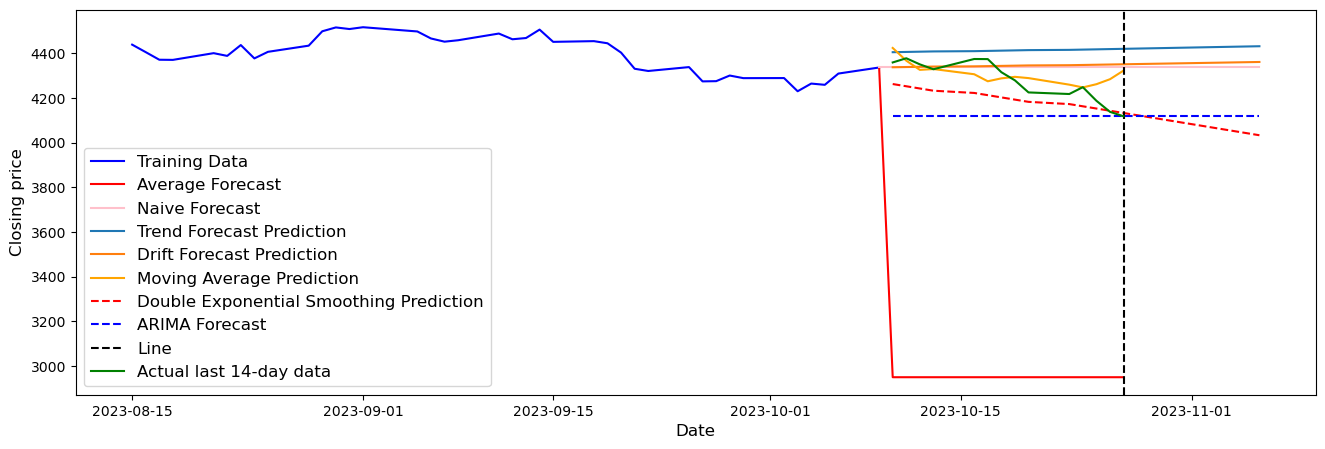

In [27]:
######### Close : all models together

# need to rerun the command for the drift:


plt.figure(figsize=(16,5))

# plt.plot(data_train.Date, data_train.Close, label="Training Data")

filtered_data = data_train[data_train['Date'] >= '2023-08-15']

plt.plot(filtered_data['Date'], 
         filtered_data['Close'],
            color='blue',
           # '-o',
            label = "Training Data")


# Find the last date in the training data
last_training_date = data_train.Date.iloc[-1]

########### Average forecast

# Plot the "testsize"-day average forecast using a line and connect it to the last training data point
plt.plot([last_training_date] + data_test.Date.tolist(), 
         [data_train.Close.iloc[-1]] + [train_close_avg] * testsize, 
         color='red', 
         #linestyle='--', 
         label="Average Forecast")

# plt.scatter(data_test.Date,
#             train_close_avg*np.ones(testsize),
#             marker='x',
#             s=150,
#             color='red',
#             label="Average Forecast")


########### Naive forecast
additional_dates = [data['Date'].iloc[-1] + timedelta(days=i) for i in range(1, 11)]

plt.plot([last_training_date] + data_test.Date.tolist()  + additional_dates, 
         [data_train.Close.iloc[-1]] + [naive_close] * (testsize+10), 
         color='pink', 
         #linestyle='--', 
         label="Naive Forecast")

########### Trend forecast
plt.plot(data_test.Date.tolist()  + additional_dates,
            trend_close_pred,
            #'r--',
            label="Trend Forecast Prediction")

############ drift forecast

plt.plot(data_test.Date.tolist()  + additional_dates,
            drift_pred_2,
            #'r--',
            label="Drift Forecast Prediction")

############ moving average
plt.plot(data_test.Date, moving_average_close[-testsize:], color='orange', label="Moving Average Prediction")

########### double exponential ############
plt.plot(data_test.Date.tolist()  + additional_dates, 
         exp_smooth_close.forecast(testsize+future_predicion_days),
         'r--',
         label="Double Exponential Smoothing Prediction")

################# arima ###################
plt.plot(data_test.Date.tolist()  + additional_dates, 
         arima.forecast(testsize + future_predicion_days),
         'b--',
         label="ARIMA Forecast")

plt.axvline(x = data_test.Date.iloc[-1], 
         color = 'black',  linestyle = '--', label="Line")

# plot the actual data of the last testsize days
plt.plot(data_test.Date, data_test.Close, color='green', label="Actual last "+str(testsize)+"-day data")

plt.legend(fontsize=12)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Closing price", fontsize=12)

#plt.ylim(4000,4400)

# plt.title("Average forecast", fontsize=14)

    
plt.show()